In [1]:
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras import layers, models

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
pd.set_option("display.max_columns", None)


In [2]:
PROJECT_ROOT = ".."  # this notebook is in notebooks/, so .. is project root
CLEAN_DATA_PATH = os.path.join(PROJECT_ROOT, "data", "processed", "accidents_india_clean.csv")

USED_FEATURES = [
    "Day_of_week",
    "Age_band_of_driver",
    "Sex_of_driver",
    "Weather_conditions",
    "Light_conditions",
    "Number_of_vehicles_involved",
    "Number_of_casualties",
    "Hour",
]

TARGET_COL = "Accident_Severity"


In [3]:
df = pd.read_csv(CLEAN_DATA_PATH)
df.head()


,Time,Day_of_week,Age_band_of_driver,Sex_of_driver,Educational_level,Vehicle_driver_relation,Driving_experience,Type_of_vehicle,Owner_of_vehicle,Service_year_of_vehicle,Defect_of_vehicle,Area_accident_occured,Lanes_or_Medians,Road_allignment,Types_of_Junction,Road_surface_type,Road_surface_conditions,Light_conditions,Weather_conditions,Type_of_collision,Number_of_vehicles_involved,Number_of_casualties,Vehicle_movement,Casualty_class,Sex_of_casualty,Age_band_of_casualty,Casualty_severity,Work_of_casuality,Fitness_of_casuality,Pedestrian_movement,Cause_of_accident,Accident_Severity,Hour
0,17:02:00,Monday,18-30,Male,Above high school,Employee,1-2yr,Automobile,Owner,Above 10yr,No defect,Residential areas,NaN,Tangent road with flat terrain,No junction,Asphalt roads,Dry,Daylight,Normal,Collision with roadside-parked vehicles,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Moving Backward,Slight Injury,17
1,17:02:00,Monday,31-50,Male,Junior high school,Employee,Above 10yr,Public (> 45 seats),Owner,5-10yrs,No defect,Office areas,Undivided Two way,Tangent road with flat terrain,No junction,Asphalt roads,Dry,Daylight,Normal,Vehicle with vehicle collision,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury,17
2,17:02:00,Monday,18-30,Male,Junior high school,Employee,1-2yr,Lorry (41?100Q),Owner,NaN,No defect,Recreational areas,other,NaN,No junction,Asphalt roads,Dry,Daylight,Normal,Collision with roadside objects,2,2,Going straight,Driver or rider,Male,31-50,3,Driver,NaN,Not a Pedestrian,Changing lane to the left,Serious Injury,17
3,1:06:00,Sunday,18-30,Male,Junior high school,Employee,5-10yr,Public (> 45 seats),Governmental,NaN,No defect,Office areas,other,Tangent road with mild grade and flat terrain,Y Shape,Earth roads,Dry,Darkness - lights lit,Normal,Vehicle with vehicle collision,2,2,Going straight,Pedestrian,Female,18-30,3,Driver,Normal,Not a Pedestrian,Changing lane to the right,Slight Injury,1
4,1:06:00,Sunday,18-30,Male,Junior high school,Employee,2-5yr,NaN,Owner,5-10yrs,No defect,Industrial areas,other,Tangent road with flat terrain,Y Shape,Asphalt roads,Dry,Darkness - lights lit,Normal,Vehicle with vehicle collision,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury,1


In [4]:
df.shape, df[TARGET_COL].value_counts()


((12316, 33),
 Accident_Severity
 Slight Injury     10415
 Serious Injury     1743
 Fatal injury        158
 Name: count, dtype: int64)

In [5]:
# Use only the 8 selected features
X = df[USED_FEATURES].copy()
y_text = df[TARGET_COL]

# Encode labels to integers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_text)

print("Classes:", label_encoder.classes_)

# Train/val/test split (same pattern as scripts)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

X_train.shape, X_val.shape, X_test.shape


Classes: ['Fatal injury' 'Serious Injury' 'Slight Injury']


((7389, 8), (2463, 8), (2464, 8))

In [6]:
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "bool"]).columns.tolist()

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

preprocessor


,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


In [7]:
log_reg_clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("clf", LogisticRegression(max_iter=200, n_jobs=-1)),
    ]
)

log_reg_clf.fit(X_train, y_train)

y_val_pred_lr = log_reg_clf.predict(X_val)
val_acc_lr = accuracy_score(y_val, y_val_pred_lr)
val_f1_lr = f1_score(y_val, y_val_pred_lr, average="macro")

print("=== Logistic Regression (Validation) ===")
print("Accuracy:", val_acc_lr)
print("Macro F1:", val_f1_lr)
print(classification_report(y_val, y_val_pred_lr, target_names=label_encoder.classes_))


=== Logistic Regression (Validation) ===
Accuracy: 0.8457166057653268
Macro F1: 0.3054700102654348
                precision    recall  f1-score   support

  Fatal injury       0.00      0.00      0.00        32
Serious Injury       0.00      0.00      0.00       348
 Slight Injury       0.85      1.00      0.92      2083

      accuracy                           0.85      2463
     macro avg       0.28      0.33      0.31      2463
  weighted avg       0.72      0.85      0.78      2463



/Users/souravshaw/Desktop/Traffic/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/souravshaw/Desktop/Traffic/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/souravshaw/Desktop/Traffic/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

In [8]:
rf_clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("clf", RandomForestClassifier(
            n_estimators=200,
            random_state=42,
            n_jobs=-1,
            class_weight=None  # intentionally no balancing here
        )),
    ]
)

rf_clf.fit(X_train, y_train)

y_val_pred_rf = rf_clf.predict(X_val)
val_acc_rf = accuracy_score(y_val, y_val_pred_rf)
val_f1_rf = f1_score(y_val, y_val_pred_rf, average="macro")

print("=== Random Forest (Validation) ===")
print("Accuracy:", val_acc_rf)
print("Macro F1:", val_f1_rf)
print(classification_report(y_val, y_val_pred_rf, target_names=label_encoder.classes_))


=== Random Forest (Validation) ===
Accuracy: 0.8444985789687373
Macro F1: 0.5637822696646225
                precision    recall  f1-score   support

  Fatal injury       0.58      0.34      0.43        32
Serious Injury       0.48      0.27      0.35       348
 Slight Injury       0.88      0.95      0.91      2083

      accuracy                           0.84      2463
     macro avg       0.65      0.52      0.56      2463
  weighted avg       0.82      0.84      0.83      2463



In [9]:
baseline_results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest"],
    "Val_Accuracy": [val_acc_lr, val_acc_rf],
    "Val_Macro_F1": [val_f1_lr, val_f1_rf],
})

baseline_results


,Model,Val_Accuracy,Val_Macro_F1
0,Logistic Regression,0.845717,0.305470
1,Random Forest,0.844499,0.563782


In [10]:
# Fit preprocessor on train only
preprocessor_ann = preprocessor.fit(X_train)

X_train_proc = preprocessor_ann.transform(X_train)
X_val_proc = preprocessor_ann.transform(X_val)
X_test_proc = preprocessor_ann.transform(X_test)

if hasattr(X_train_proc, "toarray"):
    X_train_proc = X_train_proc.toarray()
    X_val_proc = X_val_proc.toarray()
    X_test_proc = X_test_proc.toarray()

X_train_proc.shape, X_val_proc.shape, X_test_proc.shape


((7389, 31), (2463, 31), (2464, 31))

In [11]:
input_dim = X_train_proc.shape[1]
num_classes = len(label_encoder.classes_)

def build_ann(input_dim, num_classes):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(32, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

ann_vanilla = build_ann(input_dim, num_classes)
ann_vanilla.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,227 (16.51 KB)

 Trainable params: 4,227 (16.51 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1,
)

history_vanilla = ann_vanilla.fit(
    X_train_proc,
    y_train,
    validation_data=(X_val_proc, y_val),
    epochs=50,
    batch_size=64,
    verbose=1,
    callbacks=[es],
)


Epoch 1/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8077 - loss: 0.5873 - val_accuracy: 0.8457 - val_loss: 0.4812
Epoch 2/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8456 - loss: 0.4737 - val_accuracy: 0.8457 - val_loss: 0.4716
Epoch 3/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8460 - loss: 0.4667 - val_accuracy: 0.8457 - val_loss: 0.4679
Epoch 4/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8456 - loss: 0.4622 - val_accuracy: 0.8457 - val_loss: 0.4647
Epoch 5/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8461 - loss: 0.4568 - val_accuracy: 0.8457 - val_loss: 0.4646
Epoch 6/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8469 - loss: 0.4532 - val_accuracy: 0.8461 - val_loss: 0.4605
Epoch 7/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8479 - loss: 0.4513 - val_accuracy: 0.8461 - val_loss: 0.4581
Epoch 8/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8471 - loss: 0.4455 - val_accuracy: 0.

In [13]:
val_probs_vanilla = ann_vanilla.predict(X_val_proc, verbose=0)
y_val_pred_vanilla = np.argmax(val_probs_vanilla, axis=1)

val_acc_vanilla = accuracy_score(y_val, y_val_pred_vanilla)
val_f1_vanilla = f1_score(y_val, y_val_pred_vanilla, average="macro")

print("=== ANN Vanilla (Validation) ===")
print("Accuracy:", val_acc_vanilla)
print("Macro F1:", val_f1_vanilla)
print(classification_report(y_val, y_val_pred_vanilla, target_names=label_encoder.classes_))


=== ANN Vanilla (Validation) ===
Accuracy: 0.8509947218838815
Macro F1: 0.3337122748073915
                precision    recall  f1-score   support

  Fatal injury       0.00      0.00      0.00        32
Serious Injury       0.83      0.04      0.08       348
 Slight Injury       0.85      1.00      0.92      2083

      accuracy                           0.85      2463
     macro avg       0.56      0.35      0.33      2463
  weighted avg       0.84      0.85      0.79      2463



/Users/souravshaw/Desktop/Traffic/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/souravshaw/Desktop/Traffic/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/souravshaw/Desktop/Traffic/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

In [14]:
print("Class distribution BEFORE SMOTE (y_train):")
unique, counts = np.unique(y_train, return_counts=True)
for cls, cnt in zip(unique, counts):
    print(f"{cls} ({label_encoder.inverse_transform([cls])[0]}): {cnt}")

sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train_proc, y_train)

print("\nClass distribution AFTER SMOTE (y_train_smote):")
unique_res, counts_res = np.unique(y_train_smote, return_counts=True)
for cls, cnt in zip(unique_res, counts_res):
    print(f"{cls} ({label_encoder.inverse_transform([cls])[0]}): {cnt}")


Class distribution BEFORE SMOTE (y_train):
0 (Fatal injury): 95
1 (Serious Injury): 1046
2 (Slight Injury): 6248

Class distribution AFTER SMOTE (y_train_smote):
0 (Fatal injury): 6248
1 (Serious Injury): 6248
2 (Slight Injury): 6248


In [15]:
ann_smote = build_ann(input_dim, num_classes)

es_smote = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    verbose=1,
)

history_smote = ann_smote.fit(
    X_train_smote,
    y_train_smote,
    validation_data=(X_val_proc, y_val),
    epochs=100,
    batch_size=64,
    verbose=1,
    callbacks=[es_smote],
)


Epoch 1/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5087 - loss: 0.9548 - val_accuracy: 0.5891 - val_loss: 0.8723
Epoch 2/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - accuracy: 0.6122 - loss: 0.7869 - val_accuracy: 0.5286 - val_loss: 0.8231
Epoch 3/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step - accuracy: 0.6571 - loss: 0.6973 - val_accuracy: 0.6358 - val_loss: 0.7603
Epoch 4/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - accuracy: 0.6810 - loss: 0.6415 - val_accuracy: 0.5404 - val_loss: 0.7967
Epoch 5/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - accuracy: 0.7008 - loss: 0.6022 - val_accuracy: 0.5018 - val_loss: 0.8398
Epoch 6/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - accuracy: 0.7166 - loss: 0.5785 - val_accuracy: 0.5570 - val_loss: 0.7784
Epoch 7/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step - accuracy: 0.7209 - loss: 0.5592 - val_accuracy: 0.5518 - val_loss: 0.7922
Epoch 8/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - accuracy: 0.7287 - loss: 0.5

In [16]:
val_probs_smote = ann_smote.predict(X_val_proc, verbose=0)
y_val_pred_smote = np.argmax(val_probs_smote, axis=1)

val_acc_smote = accuracy_score(y_val, y_val_pred_smote)
val_f1_smote = f1_score(y_val, y_val_pred_smote, average="macro")

print("=== ANN + SMOTE (Validation) ===")
print("Accuracy:", val_acc_smote)
print("Macro F1:", val_f1_smote)
print(classification_report(y_val, y_val_pred_smote, target_names=label_encoder.classes_))


=== ANN + SMOTE (Validation) ===
Accuracy: 0.6358099878197321
Macro F1: 0.37731335002303235
                precision    recall  f1-score   support

  Fatal injury       0.06      0.41      0.10        32
Serious Injury       0.21      0.36      0.27       348
 Slight Injury       0.87      0.69      0.77      2083

      accuracy                           0.64      2463
     macro avg       0.38      0.48      0.38      2463
  weighted avg       0.77      0.64      0.69      2463



In [17]:
comparison = pd.DataFrame([
    {"Model": "Logistic Regression", "Val_Accuracy": val_acc_lr, "Val_Macro_F1": val_f1_lr},
    {"Model": "Random Forest",       "Val_Accuracy": val_acc_rf, "Val_Macro_F1": val_f1_rf},
    {"Model": "ANN Vanilla",         "Val_Accuracy": val_acc_vanilla, "Val_Macro_F1": val_f1_vanilla},
    {"Model": "ANN + SMOTE",         "Val_Accuracy": val_acc_smote, "Val_Macro_F1": val_f1_smote},
])

comparison


,Model,Val_Accuracy,Val_Macro_F1
0,Logistic Regression,0.845717,0.305470
1,Random Forest,0.844499,0.563782
2,ANN Vanilla,0.850995,0.333712
3,ANN + SMOTE,0.635810,0.377313


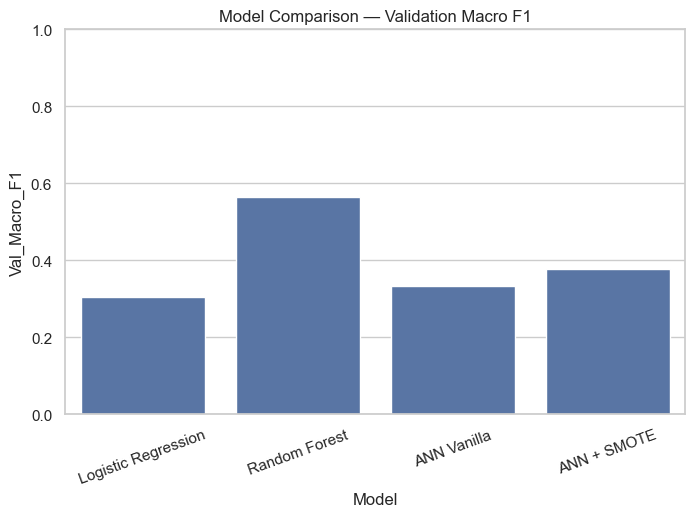

In [18]:
plt.figure(figsize=(8,5))
sns.barplot(data=comparison, x="Model", y="Val_Macro_F1")
plt.title("Model Comparison — Validation Macro F1")
plt.xticks(rotation=20)
plt.ylim(0, 1)
plt.show()
